In [7]:
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

import pandas as pd


In [8]:
data = pd.read_csv('/mnt/d/mlpp/data/prices-split-adjusted.csv')

In [9]:
data['return'] = (data['close'] / data['open']) - 1

In [10]:
arr = data['return'].values

In [11]:
y = torch.from_numpy(arr)
# y = torch.unsqueeze(y,1)
y = y.type(torch.FloatTensor)

In [12]:
y.shape

torch.Size([851264])

## Trying with fixed number of components

In [13]:
n_comp = 10

In [14]:
# Reference: https://pyro.ai/examples/gmm.html
@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(n_comp)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', n_comp):
        locs = pyro.sample('locs', dist.Normal(0.0004, 0.0002))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        assignment.shape
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

# Using AutoDelta guide (MAP estimator)
global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

In [15]:
device = torch.device('cpu')

In [16]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

In [17]:
# n_steps = 5000
# # do gradient steps
# for step in range(n_steps):
#     svi.step(y)

In [18]:
losses = []
for i in range(1000):
    loss = svi.step(y[:10000])
    losses.append(loss)
    print(loss)

10655.3447265625
1258615.375
67049.046875
306096.65625
588528.0625
281266.125
14153.2177734375
90216.5859375
220738.453125
149193.203125
19972.2421875
16040.3857421875
79478.5625
70681.703125
11782.220703125
-564.509033203125
27174.57421875
26052.158203125
-877.67822265625
-6078.103515625
6121.2353515625
2586.6748046875
-9969.390625
-9711.2666015625
-5367.08154296875
-10271.2158203125
-15106.0947265625
-13402.47265625
-13680.1201171875
-17423.55859375
-18253.060546875
-17843.455078125
-19811.8828125
-21272.806640625
-21269.072265625
-22286.763671875
-23510.447265625
-23772.3515625
-24370.0
-25163.14453125
-25409.9765625
-25746.357421875
-26122.833984375
-26230.74609375
-26337.779296875
-26416.55859375
-26423.046875
-26381.779296875
-26385.376953125
-26363.517578125
-26332.853515625
-26365.888671875
-26359.51171875
-26385.634765625
-26411.263671875
-26426.806640625
-26444.623046875
-26458.6640625
-26462.615234375
-26467.984375
-26470.00390625
-26467.52734375
-26469.923828125
-26467.7773

/mnt/c/Users/aksmi/Desktop/Drive/Fall '19/Courses/ML with Probabilistic Programming/course_repo/probprog/lib/python3.6/site-packages/pyro/infer/traceenum_elbo.py:391: UserWarning: Encountered NaN: loss
  warn_if_nan(loss, "loss")


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


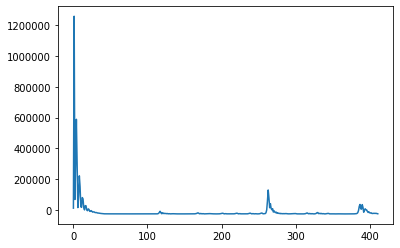

In [19]:
plt.plot(losses)

In [20]:
# Initializations
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(n_comp), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (y.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', y[torch.multinomial(torch.ones(len(y)) / len(y), n_comp)]);
    loss = svi.loss(model, global_guide, y)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
# initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 41, initial_loss = -2354894.0


In [21]:
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200):
    loss = svi.step(y)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')



...................................................................................................
...................................................................................................

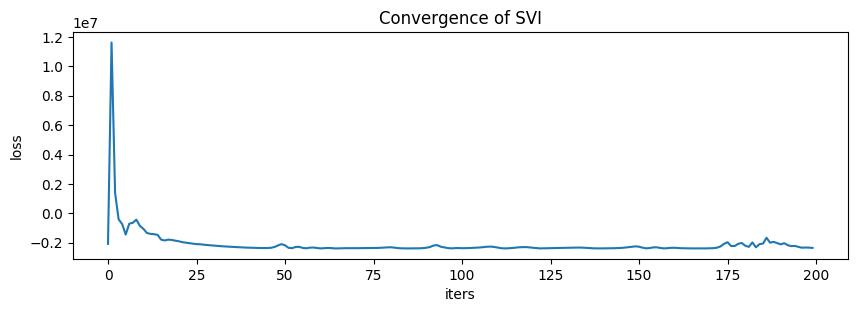

In [22]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [23]:
# MAP Estimates
map_estimates = global_guide(y)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.04611946 0.01727542 0.040063   0.0516015  0.03600177 0.43110162
 0.05298012 0.0721241  0.04051467 0.21221834]
locs = [-1.3866462e-05 -3.9531577e-02 -5.8389427e-03 -6.4188614e-04
  2.8955722e-03  6.6483212e-03  3.7727472e-03 -5.6674941e-03
  3.5401846e-03  2.7374390e-03]
scale = 0.01425514928996563


In [31]:
global_guide()

{'weights': tensor([0.0461, 0.0173, 0.0401, 0.0516, 0.0360, 0.4311, 0.0530, 0.0721, 0.0405,
         0.2122], grad_fn=<ExpandBackward>),
 'scale': tensor(0.0143, grad_fn=<ExpandBackward>),
 'locs': tensor([-1.3866e-05, -3.9532e-02, -5.8389e-03, -6.4189e-04,  2.8956e-03,
          6.6483e-03,  3.7727e-03, -5.6675e-03,  3.5402e-03,  2.7374e-03],
        grad_fn=<ExpandBackward>)}